# Análise Exploratória

In [38]:
# Importando as Bibliotecas
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.dates import DateFormatter
from matplotlib import ticker

## Inicialização Spark e carregamento dos dados

In [2]:
spark = SparkSession.builder \
    .master('local[*]') \
    .appName('Forecasting com Spark') \
    .getOrCreate()

spark

In [3]:
# Antes de carregar os dados, vamos explicitar a estrutura dos dados que
# serão carregados

schema = StructType([
    StructField('day_of_purchase', StringType(), False), # será carregado como string para posterior manipulação
    StructField('seller_id', StringType(), False),
    StructField('customer_id', StringType(), False),
    StructField('order_id', StringType(), False),
    StructField('order_status', StringType(), False),
    StructField('order_item_id', IntegerType(), False),
    StructField('product_id', StringType(), False),
    StructField('product_category_name', StringType(), False),
    StructField('price', DoubleType(), False),
    StructField('freight_value', DoubleType(), False),
    StructField('customer_city', StringType(), False),
    StructField('seller_city', StringType(), False)
])

In [4]:
#Importando os dados
path_csv = '../dados/forecast_query.csv'

df = spark.read.csv(
    path_csv,
    inferSchema=True,
    header=True,
    schema=schema
)

## Compreensão dos Dados

In [5]:
# Verificando se os tipos foram determinados corretamente de acordo com o 
# struct type previamente definido
df.printSchema()

root
 |-- day_of_purchase: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- seller_city: string (nullable = true)



In [6]:
# Visualizar as primeiras cinco linhas do Spark Dataframe
df.limit(5).toPandas()

,day_of_purchase,seller_id,customer_id,order_id,order_status,order_item_id,product_id,product_category_name,price,freight_value,customer_city,seller_city
0,2016-09-04 21:15:19,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,1,c1488892604e4ba5cff5b4eb4d595400,moveis_decoracao,39.99,31.67,boa vista,monte siao
1,2016-09-04 21:15:19,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2,f293394c72c9b5fafd7023301fc21fc2,moveis_decoracao,32.90,31.67,boa vista,monte siao
2,2016-09-15 12:16:38,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,1,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,curitiba
3,2016-09-15 12:16:38,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,2,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,curitiba
4,2016-09-15 12:16:38,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,3,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,curitiba


In [7]:
# Verificando quantos registros temos no dataset
print('Quantidade de vendas:', df.count())

Quantidade de vendas: 112108


In [8]:
# Verificando se existen colunas com valores nulos
df.select(
    [f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) 
        for c in df.columns]

).toPandas()

,day_of_purchase,seller_id,customer_id,order_id,order_status,order_item_id,product_id,product_category_name,price,freight_value,customer_city,seller_city
0,0,0,0,0,0,0,0,0,0,0,0,0


### Separação dos Dados

In [9]:
# Transformar a coluna `data_of_purchase` para o tipo data (vamos aproveitar somente a data, a hora por enquanto vamos descartar)

df = df.withColumn('day_of_purchase', f.to_date(df['day_of_purchase']))
df.limit(5).toPandas()

,day_of_purchase,seller_id,customer_id,order_id,order_status,order_item_id,product_id,product_category_name,price,freight_value,customer_city,seller_city
0,2016-09-04,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,1,c1488892604e4ba5cff5b4eb4d595400,moveis_decoracao,39.99,31.67,boa vista,monte siao
1,2016-09-04,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2,f293394c72c9b5fafd7023301fc21fc2,moveis_decoracao,32.90,31.67,boa vista,monte siao
2,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,1,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,curitiba
3,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,2,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,curitiba
4,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,3,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,curitiba


In [10]:
# Vamos verificar qual é o intervalo do nosso dataset

df\
    .select(f.min('day_of_purchase').alias('first_date'), 
            f.max('day_of_purchase').alias('last_date'),
            f.datediff(f.max('day_of_purchase'), 
                        f.min('day_of_purchase')).alias('interval_days'))\
    .toPandas()

,first_date,last_date,interval_days
0,2016-09-04,2018-09-03,729


O dataset compreende um período de 2 anos, ou 24 meses.   
Vamos analizar o comportamento dos primeiros 18 meses, entender os padrões desse intervalo e modelar o nosso caso.  
O restante será utilizado para validarmos o resultado.

In [11]:
df\
    .select(f.min('day_of_purchase').alias('first_date'), 
            f.add_months(f.min('day_of_purchase'), 18).alias('cut_off_date'))\
    .show()

+----------+------------+
|first_date|cut_off_date|
+----------+------------+
|2016-09-04|  2018-03-04|
+----------+------------+



In [12]:
df_analise = df\
    .select('*')\
    .where('day_of_purchase <= "2018-03-04"')

df_validacao = df\
    .select('*')\
    .where('day_of_purchase > "2018-03-04"')

In [13]:
df_analise.toPandas()

,day_of_purchase,seller_id,customer_id,order_id,order_status,order_item_id,product_id,product_category_name,price,freight_value,customer_city,seller_city
0,2016-09-04,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,1,c1488892604e4ba5cff5b4eb4d595400,moveis_decoracao,39.99,31.67,boa vista,monte siao
1,2016-09-04,1554a68530182680ad5c8b042c3ab563,08c5351a6aca1c1589a38f244edeee9d,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2,f293394c72c9b5fafd7023301fc21fc2,moveis_decoracao,32.90,31.67,boa vista,monte siao
2,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,1,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,curitiba
3,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,2,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,curitiba
4,2016-09-15,ecccfa2bb93b34a3bf033cc5d1dcdc69,86dc2ffce2dfff336de2f386a786e574,bfbd0f9bdef84302105ad712db648a6c,delivered,3,5a6b04657a4c5ee34285d1e4619a96b4,beleza_saude,44.99,2.83,sao joaquim da barra,curitiba
...,...,...,...,...,...,...,...,...,...,...,...,...
67830,2018-03-04,4da0e408c99d2fdc2126dc9fce518060,03f2dda26a1b89b7cf91dcd8a41feb96,b0a2ec49c45ae3f6241044d9434ce3b2,delivered,3,e1dae76b5f1c39746a05aebb9ea23d1d,esporte_lazer,33.60,15.43,ipira,cornelio procopio
67831,2018-03-04,620c87c171fb2a6dd6e8bb4dec959fc6,bbf19f753671013db6812d683007ab28,0ea6fb65c44f0a557e7ee0dc86d66c04,delivered,1,341d85d688ecc3353cf2a968e7ad0dbf,beleza_saude,119.90,15.59,montes claros,petropolis
67832,2018-03-04,17e34d8224d27a541263c4c64b11a56b,8372eb499d7f5baf1f41b42cd6597074,da36f0ed6b7669628846afd6d75a9a7c,delivered,1,9f82fdef2a36bb15d22d70af1aedb3ce,ferramentas_jardim,1099.00,74.56,sao paulo,riberao preto
67833,2018-03-04,0df3984f9dfb3d49ac6366acbd3bbb85,0c72632077a893989155f0507aed5927,429db7656bb9bd2a1fc038fcbc4fa159,delivered,1,921d31a1daa51460b7a95ea5f3ab64d5,beleza_saude,88.90,17.06,japira,betim


In [14]:
df_validacao.toPandas()

,day_of_purchase,seller_id,customer_id,order_id,order_status,order_item_id,product_id,product_category_name,price,freight_value,customer_city,seller_city
0,2018-03-05,25cf099de44674fde97473224f9d59ab,8c9b6ba8f384bdf1a92424bc1b9401e9,d4646c4ab91c910a48e894192d0c5a97,delivered,1,b8d33fa8d1aa09f4adaf070e0db3a5d9,automotivo,10.00,14.10,rio de janeiro,cotia
1,2018-03-05,a3a38f4affed601eb87a97788c949667,f343704e8d64e463a7147138a8d21b6b,3ae5cb75e3aaf3d9e99637e6c07032e0,delivered,1,cd935d283d47f1050c505e1c39c48b67,esporte_lazer,69.90,17.00,bage,joinville
2,2018-03-05,e2aee0892199b1d92530e371abd825bf,c6e3e7289d31172d406b128104f435d8,a63792bf510613cc7d8182ece331499e,delivered,1,e4e9fa024c5f014419b395452a41987c,esporte_lazer,119.90,65.65,porto alegre,rolandia
3,2018-03-05,0d85bbda9889ce1f7e63778d24f346eb,63f9f01b26b742afbd95beb988883c52,c2ebe69807422446d5e8edb2060da5e9,delivered,1,0a04ebe637717bf7f0a9290adb51971f,papelaria,139.90,60.15,macapa,uberlandia
4,2018-03-05,7d13fca15225358621be4086e1eb0964,3136355c994d4e466d7b7fc497727e1a,6db6009ebbcd3dd392a0b9fdc4cec226,delivered,1,53b36df67ebb7c41585e8d54d6772e08,relogios_presentes,125.00,12.37,sao paulo,ribeirao preto
...,...,...,...,...,...,...,...,...,...,...,...,...
44268,2018-08-29,67bf6941ba2f1fa1d02c375766bc3e53,e60df9449653a95af4549bbfcb18a6eb,0b223d92c27432930dfe407c6aea3041,delivered,2,2b4472df15512a2825ae86fd9ae79335,moveis_cozinha_area_de_servico_jantar_e_jardim,209.00,46.48,curitiba,curitiba
44269,2018-08-29,2a84855fd20af891be03bc5924d2b453,6e353700bc7bcdf6ebc15d6de16d7002,168626408cb32af0ffaf76711caae1dc,delivered,1,bdcf6a834e8faa30dac3886c7a58e92e,beleza_saude,45.90,15.39,paracatu,belo horizonte
44270,2018-08-29,7d7866a99a8656a42c7ff6352a433410,496630b6740bcca28fce9ba50d8a26ef,03ef5dedbe7492bdae72eec50764c43f,delivered,1,c7f27c5bef2338541c772b5776403e6a,artigos_de_festas,24.90,8.33,sao caetano do sul,sao paulo
44271,2018-08-29,9f505651f4a6abe901a56cdc21508025,898b7fee99c4e42170ab69ba59be0a8b,35a972d7f8436f405b56e36add1a7140,delivered,1,d04857e7b4b708ee8b8b9921163edba3,informatica_acessorios,84.99,8.76,limeira,sao paulo


A partir deste ponto toda a análise será realizada no `df_analise`.

In [15]:
# Verificando qtas categorias de produto o dataset possui
df_analise\
    .select(f.count_distinct('product_category_name').alias('qtd categorias'))\
    .show()


+--------------+
|qtd categorias|
+--------------+
|            73|
+--------------+



Existem várias categorias neste dataset, e talvez não seja viável trabalharmos com todos eles.  
Vamos investigar melhor as categorias para vermos se podemos refinar as pesquisas.

In [16]:
# Criando os totais para realizar comparações.
total_item = df_analise.count()
sum_price = df_analise.select('price').agg(f.sum('price').alias('total')).toPandas()

sum_price = int(sum_price['total'])

total_item, sum_price

(67835, 8068268)

In [17]:
# Ordenando por quantidade de produtos
df_analise\
    .select('price', 'product_category_name')\
    .groupBy('product_category_name')\
    .agg(
        f.round(f.sum('price'), 2).alias('total_preco'),
        f.round(f.sum('price') / sum_price, 2).alias('pct_total_preco'),
        f.count('product_category_name').alias('qtd_produtos'),
        (f.count('product_category_name') / total_item).alias('pct_qtd_produtos')
    )\
    .orderBy('qtd_produtos', ascending=False)\
    .limit(20)\
    .toPandas()


,product_category_name,total_preco,pct_total_preco,qtd_produtos,pct_qtd_produtos
0,cama_mesa_banho,644207.81,0.08,6857,0.101084
1,esporte_lazer,625755.87,0.08,5477,0.080740
2,moveis_decoracao,443639.15,0.05,5320,0.078426
3,beleza_saude,660097.74,0.08,5098,0.075153
4,informatica_acessorios,596205.97,0.07,4898,0.072205
5,utilidades_domesticas,307449.03,0.04,3688,0.054367
6,relogios_presentes,640753.23,0.08,3024,0.044579
7,ferramentas_jardim,324978.46,0.04,3021,0.044535
8,telefonia,173570.97,0.02,2964,0.043694
9,brinquedos,349197.20,0.04,2945,0.043414


In [18]:
# Ordenando pelo preco do produto

df_analise\
    .select('price', 'product_category_name')\
    .groupBy('product_category_name')\
    .agg(
        f.round(f.sum('price'), 2).alias('total_preco'),
        f.round(f.sum('price') / sum_price, 2).alias('pct_total_preco'),
        f.count('product_category_name').alias('qtd_produtos'),
        (f.count('product_category_name') / total_item).alias('pct_qtd_produtos')
    )\
    .orderBy('total_preco', ascending=False)\
    .limit(20)\
    .toPandas()


,product_category_name,total_preco,pct_total_preco,qtd_produtos,pct_qtd_produtos
0,beleza_saude,660097.74,0.08,5098,0.075153
1,cama_mesa_banho,644207.81,0.08,6857,0.101084
2,relogios_presentes,640753.23,0.08,3024,0.044579
3,esporte_lazer,625755.87,0.08,5477,0.080740
4,informatica_acessorios,596205.97,0.07,4898,0.072205
5,cool_stuff,464983.76,0.06,2834,0.041778
6,moveis_decoracao,443639.15,0.05,5320,0.078426
7,brinquedos,349197.20,0.04,2945,0.043414
8,ferramentas_jardim,324978.46,0.04,3021,0.044535
9,automotivo,321621.74,0.04,2217,0.032682


Apesar de existir vários tipos de produtos, aparentemente os valores estão bem distribuiídos - por enquanto vamos manter dessa forma.  
Ao ordenar pela quantidade, notamos que existe uma categoria de produto que está como NULL.  
Provavelmente saiu assim quando realizamos a query no banco. Vamos deletar esses itens futuramente.

### Tratando a categoria de produto Nula

In [19]:
df_analise \
    .select('product_category_name', 'price')\
    .where(df['product_category_name'] == 'NULL')\
    .agg(
        f.count('product_category_name').alias('qtd_itens_nulos'),
        f.sum('price').alias('soma_precos_nulos')
    )\
    .toPandas()

,qtd_itens_nulos,soma_precos_nulos
0,1249,143166.93


In [20]:
# Pegando o valor total das vendas

df_analise.select(f.sum('price').alias('total price')).show(truncate=False)

+-----------------+
|total price      |
+-----------------+
|8068268.999999259|
+-----------------+



In [21]:
print((1249 / 67835) * 100)
print((178572.55 / 8068268.999999259) * 100)

1.8412324021522812
2.213269661683521


Como se trata se um uma proporção pequena, vamos simplismente dropar esses registros.

In [22]:
df_analise = df_analise.filter(df_analise['product_category_name'] != 'NULL')
df_validacao = df_validacao.filter(df_validacao['product_category_name'] != 'NULL')

In [23]:
df_analise\
    .select('*')\
    .where(df_analise['product_category_name'] == 'NULL')\
    .show()

+---------------+---------+-----------+--------+------------+-------------+----------+---------------------+-----+-------------+-------------+-----------+
|day_of_purchase|seller_id|customer_id|order_id|order_status|order_item_id|product_id|product_category_name|price|freight_value|customer_city|seller_city|
+---------------+---------+-----------+--------+------------+-------------+----------+---------------------+-----+-------------+-------------+-----------+
+---------------+---------+-----------+--------+------------+-------------+----------+---------------------+-----+-------------+-------------+-----------+



In [24]:
# Ordenando por quantidade de produtos
df_analise\
    .select('price', 'product_category_name')\
    .groupBy('product_category_name')\
    .agg(
        f.round(f.sum('price'), 2).alias('total_preco'),
        f.round(f.sum('price') / sum_price, 2).alias('pct_total_preco'),
        f.count('product_category_name').alias('qtd_produtos'),
        (f.count('product_category_name') / total_item).alias('pct_qtd_produtos')
    )\
    .orderBy('qtd_produtos', ascending=False)\
    .limit(20)\
    .toPandas()

,product_category_name,total_preco,pct_total_preco,qtd_produtos,pct_qtd_produtos
0,cama_mesa_banho,644207.81,0.08,6857,0.101084
1,esporte_lazer,625755.87,0.08,5477,0.080740
2,moveis_decoracao,443639.15,0.05,5320,0.078426
3,beleza_saude,660097.74,0.08,5098,0.075153
4,informatica_acessorios,596205.97,0.07,4898,0.072205
5,utilidades_domesticas,307449.03,0.04,3688,0.054367
6,relogios_presentes,640753.23,0.08,3024,0.044579
7,ferramentas_jardim,324978.46,0.04,3021,0.044535
8,telefonia,173570.97,0.02,2964,0.043694
9,brinquedos,349197.20,0.04,2945,0.043414


### Analisando os Dados  
Neste tópico vamos explorar mais as features presentes no nosso dataset

#### Valores Numéricos  
Verificando a estatística dos valores numéricos do dataset.

In [25]:
numerical_columns = ['price', 'freight_value', 'order_item_id']
df_analise[numerical_columns]\
    .summary()\
    .toPandas()

,summary,price,freight_value,order_item_id
0,count,66586,66586,66586
1,mean,119.02054591054026,19.339099660588847,1.1973387799237076
2,stddev,177.13674345913677,14.201978847215678,0.7309644690882706
3,min,1.2,0.0,1
4,25%,39.9,13.37,1
5,50%,73.35,16.05,1
6,75%,132.97,19.94,1
7,max,6735.0,314.4,21


Alguns pontos interessantes:
* Tanto preço (valor) como o custo do frete possuem uma distribuição bastante desbalanceadas (pouca ocorrência de valores altos) e possui um desvio padrão relativamente alto;
* Mesma constatação para a quantidade de itens no pedido (order_item_id), ou seja, a maioria das compras possui somente 1 item.

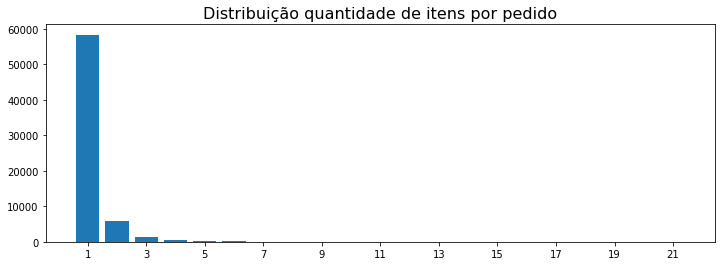

In [26]:
# Verificar quantos pedidos possuem mais de 1 item

df_pandas_qtd_item = df_analise\
    .select('*')\
    .groupBy('order_item_id')\
    .agg(f.count('order_item_id').alias('qtd_itens_pedido'))\
    .orderBy('qtd_itens_pedido', ascending=False)\
    .toPandas()

plt.figure(figsize=(12, 4))
plt.title('Distribuição quantidade de itens por pedido', fontsize=16)
plt.bar(x='order_item_id', height='qtd_itens_pedido', data=df_pandas_qtd_item)
plt.xticks(np.arange(1, 23, 2))
plt.show()

Vamos analizar o preço dos produtos

In [27]:
df_pandas_dist_price = df_analise\
    .select('price')\
    .orderBy('price')\
    .toPandas()

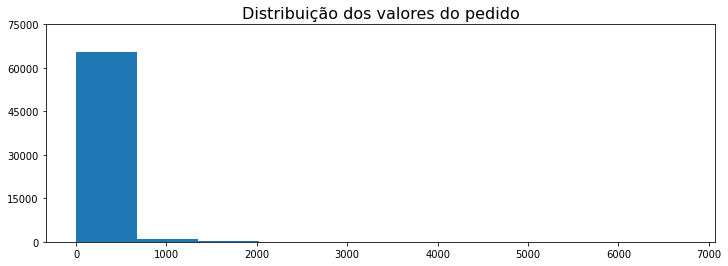

In [28]:
plt.figure(figsize=(12, 4))
plt.title('Distribuição dos valores do pedido', fontsize=16)
plt.hist(data=df_pandas_dist_price, x='price')
plt.yticks(np.arange(0, 80001, 15000))
plt.show()

Como podemos notar, grande parte dos itens tem o preço até 2000.  
Podemos considerar todo valor maior que esse como outlier e verificar como trataremos antes de modelar.

Por fim, vamos analizar o comportamento de vendas através do tempo.

In [29]:
df_pandas_serie_temporal = df_analise.toPandas()

In [30]:
df_pandas_serie_temporal = df_pandas_serie_temporal.set_index('day_of_purchase')
df_pandas_serie_temporal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66586 entries, 2016-09-04 to 2018-03-04
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   seller_id              66586 non-null  object 
 1   customer_id            66586 non-null  object 
 2   order_id               66586 non-null  object 
 3   order_status           66586 non-null  object 
 4   order_item_id          66586 non-null  int32  
 5   product_id             66586 non-null  object 
 6   product_category_name  66586 non-null  object 
 7   price                  66586 non-null  float64
 8   freight_value          66586 non-null  float64
 9   customer_city          66586 non-null  object 
 10  seller_city            66586 non-null  object 
dtypes: float64(2), int32(1), object(8)
memory usage: 5.8+ MB


In [32]:
df_pandas_serie_temporal.groupby(df_pandas_serie_temporal.index).sum('price')[['price']]

,price
day_of_purchase,
2016-09-04,72.89
2016-09-15,134.97
2016-10-03,441.98
2016-10-04,9521.17
2016-10-05,8214.55
...,...
2018-02-28,45337.29
2018-03-01,38920.07
2018-03-02,31161.51


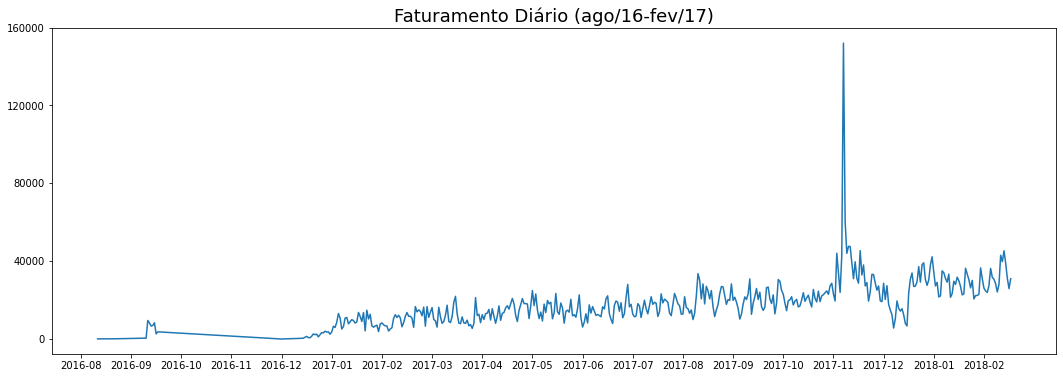

In [96]:
fig, ax = plt.subplots(figsize=(18, 6))
plt.title('Faturamento Diário (ago/16-fev/17)', fontsize=18)
plt.plot(df_pandas_serie_temporal.groupby(df_pandas_serie_temporal.index).sum('price')[['price']])

ax.set_yticks(np.arange(0, 16e4 + 1, 4e4))

ax.xaxis.set_major_locator(ticker.IndexLocator(base=30, offset=-10))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))


Com as vendas agrupadas no dia ainda está difícil identificar um padrão, sem mencionar o pico absurdo que existe no mes de novembro/17.  
Outro ponto que vale mencionar é que as vendas de 2016 pode não ajudar na modelagem, já que possui poucas vendas.

In [85]:
df_pandas_serie_temporal.groupby(df_pandas_serie_temporal.index).sum('price')['price'].sort_values(ascending=False)

day_of_purchase
2017-11-24    152050.89
2017-11-25     60471.12
2017-11-28     47576.92
2017-11-27     47561.39
2017-12-04     45424.73
                ...    
2016-10-03       441.98
2017-01-05       396.90
2016-09-15       134.97
2016-09-04        72.89
2016-12-23        10.90
Name: price, Length: 435, dtype: float64

In [ ]:
# Transformação do 'Valor total'
# df.withColumn(
#     'total_value',
#     df['price'] + df['freight_value']
# ).limit(5).toPandas()